# Case Study: classificação de *reviews* 
<br>

### Índice <a name="topo"></a>

1. [Análise de negócio](#1)
2. [Explorando os dados](#2)
3. [Pré-processamento dos dados](#3)
4. [Modelagem](#4)
5. [Avaliação do modelo](#5)

## 1. Análise de negócio

Temos aqui um conjunto de dados de uma empresa varejista, especializada em moda feminina, beleza e casa. Temos variáveis que descrevem os produtos mais vendidos, suas categorias e respectivos departamentos, além de variávies que descrevem e pontuam a satisfação dos clientes com a compra destes produtos. Nosso objetivo, depois de uma prévia exploração dos dados, será classificar as avaliações dos clientes em positivas (alto grau de satisfação) e negativas (baixo grau de satisfação). Para isso, utilizaremos a variável 'SCORE' para a construção de uma variável alvo, que compreenderá as classes 'Alto' e 'Baixo'.

## 2. Explorando os dados

### 2.1 Carregamento dos pacotes e do conjunto de dados

In [ ]:
#Carregamento dos pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.probability import FreqDist

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Carregamento do dataset
df = pd.read_excel('AMARO_DS_TEST.xlsx')
qtd_total,_ = df.shape
df.head(10)

,ID_REVIEW,PRODUCT_ID,DEPARTMENT,CATEGORY,REVIEW_TITLE,REVIEW_CONTENT,SCORE,CREATED_AT,UPDATE_AT,REVIEWER_TYPE
0,242083902.0,"""20022906""",WOMEN'S FASHION,CLOTHING,"""Linda""","""Blusa perfeita, muito linda, elegante e sexy""",5.0,"""2021-03-30T23:55:24.000Z""","""2021-03-30T23:55:31.000Z""","""verified_buyer"""
1,232278423.0,"""20022906""",WOMEN'S FASHION,CLOTHING,"""Talvez fique melho em quem tem seus medios""","""Tenho busto pequeno, não ficou um caimento no...",2.0,"""2021-02-17T18:24:10.000Z""","""2021-02-17T18:24:19.000Z""","""verified_buyer"""
2,235635542.0,"""20022906""",WOMEN'S FASHION,CLOTHING,"""Gostei""","""Ficou um pouco mais apertada do que eu imagin...",3.0,"""2021-03-02T17:03:41.000Z""","""2021-03-02T17:03:45.000Z""","""verified_buyer"""
3,33719898.0,"""20003125""",WOMEN'S FASHION,CLOTHING,"""MARAVILHOSO""","""Comprem pelo tamanho de tabela. Perfeito !!!!!""",5.0,"""2016-11-30T20:19:04.000Z""","""2017-10-07T20:50:59.000Z""","""anonymous_user"""
4,289550771.0,"""50000766""",WOMEN'S FASHION,SHOES,"""PERFEITO!""","""eu amei o sapato, chegou muito rápido e a qua...",5.0,"""2021-09-09T16:09:38.000Z""","""2021-09-09T16:09:38.000Z""","""verified_buyer"""
5,36249604.0,"""20005767""",WOMEN'S FASHION,CLOTHING,"""Amei!""","""Lindíssimo! Corte e tecido impecáveis!""",5.0,"""2017-02-10T22:37:10.000Z""","""2017-10-31T11:52:06.000Z""","""verified_buyer"""
6,59379649.0,"""20010857""",GIFT,INDEFINIDO,"""Lenço!!!""","""É lindo!!! Amei a cor e a textura, muito maci...",5.0,"""2018-05-16T11:07:51.000Z""","""2018-05-16T17:45:50.000Z""","""verified_buyer"""
7,62200141.0,"""20010857""",GIFT,INDEFINIDO,"""Lindo e ótima qualidade""","""Brinde maravilhoso. Tecido bom. Cor neutra e ...",5.0,"""2018-06-29T04:34:31.000Z""","""2018-06-29T20:33:24.000Z""","""verified_buyer"""
8,270424657.0,"""40002474""",BEAUTY & PERSONAL CARE,BODY & BATH,"""Maravilhoso""","""Maravilhoso""",5.0,"""2021-06-26T11:22:08.000Z""","""2021-06-26T11:22:20.000Z""","""verified_buyer"""
9,296518344.0,"""50100372""",WOMEN'S FASHION,ACCESSORIES,"""Bolsa Tote Maxi""","""Bolsa Tote Maxi""",1.0,"""2021-09-30T21:36:08.000Z""","""2021-09-30T21:36:52.000Z""","""verified_buyer"""


### 2.2 Análise Exploratória

In [ ]:
#Algumas informações gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID_REVIEW       50000 non-null  float64
 1   PRODUCT_ID      49954 non-null  object 
 2   DEPARTMENT      44004 non-null  object 
 3   CATEGORY        44004 non-null  object 
 4   REVIEW_TITLE    50000 non-null  object 
 5   REVIEW_CONTENT  50000 non-null  object 
 6   SCORE           50000 non-null  float64
 7   CREATED_AT      50000 non-null  object 
 8   UPDATE_AT       50000 non-null  object 
 9   REVIEWER_TYPE   50000 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.8+ MB


In [ ]:
df.isna().sum()

ID_REVIEW            0
PRODUCT_ID          46
DEPARTMENT        5996
CATEGORY          5996
REVIEW_TITLE         0
REVIEW_CONTENT       0
SCORE                0
CREATED_AT           0
UPDATE_AT            0
REVIEWER_TYPE        0
dtype: int64

Podemos notar que nosso dataframe possui duas colunas não informativas, 'ID_REVIEW' e 'PRODUCT_ID', que serão retiradas para análises futuras. Vemos também que há dados faltantes nas colunas 'DEPARTMENT' e 'CATEGORY' (da ordem de 12% do número de observações totais) que precisarão ser substituídos por um valor adequado ou removidos. Interessante notar que a variável 'REVIEW_CONTENT' pode nos dar informação sobre os valores faltantes em 'CATEGORY' (e consequentemente em 'DEPARTMENT'), mas em um primeiro momento pode ser mais vantajoso simplesmente removê-los ou substituí-los pela categoria de maior frequência.

As variáveis 'CREATED_AT' e 'UPDATE_AT' são do tipo string e deverão ser convertidas para *datetime*. Vamos remover 'UPDATE_AT', tendo em vista que a informação que podemos retirar delas é redundante. Já as variáveis 'REVIEW_TITLE' e 'REVIEW_CONTENT' deverão ser tratadas com técnicas adequadas de *Natural Language Processing* (NLP). Note que pode haver erros de digitação e ou tipográficos nestes textos. Por fim, as variáveis categóricas 'REVIEWER_TYPE', 'DEPARTMENT' e 'CATEGORY' precisarão ser convertidas em numéricas para que possamos aplicar modelos de *machine learning* ao problema. 

Vamos agora visualizar as distribuições das variáveis de interesse.

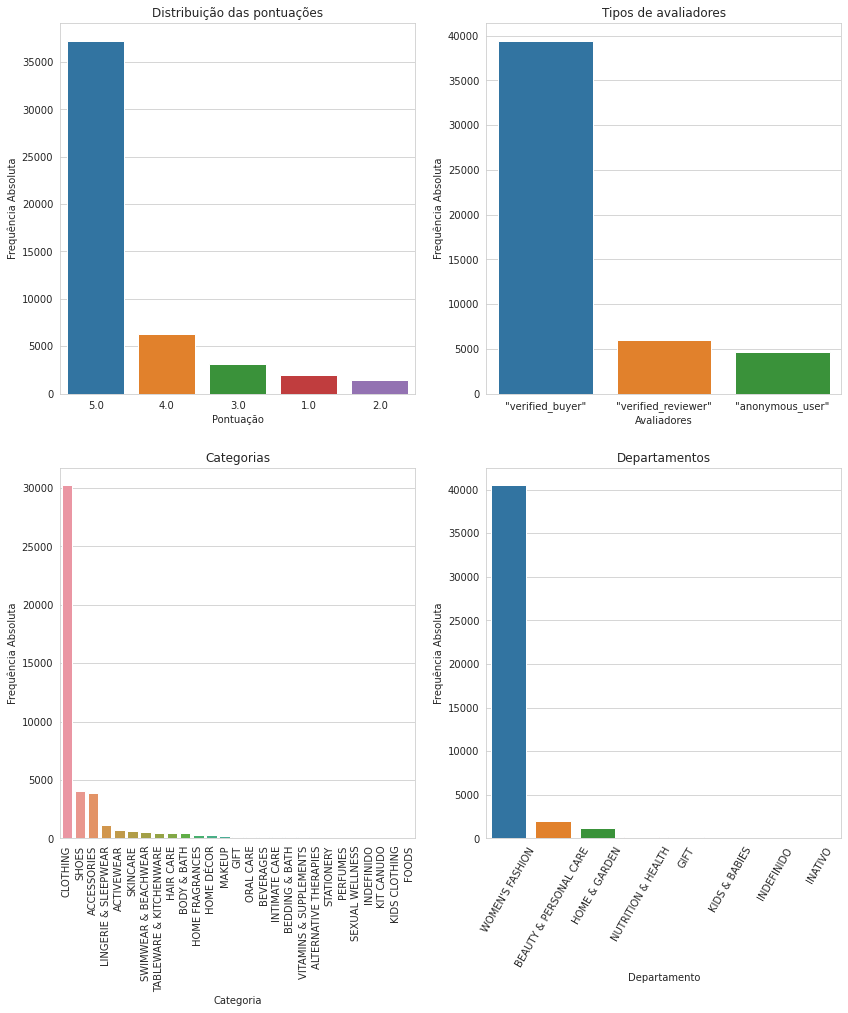

In [ ]:
def plot_dist(var, n_row, n_col, title, x_label, data, rotation = 0):
    f = sns.countplot(ax = axes[n_row, n_col], x = var, data = data, order = data[var].value_counts().index)
    f.set(title = title, xlabel = x_label, ylabel = 'Frequência Absoluta')
    f.tick_params(axis="x", rotation = rotation)
    return None

fig, axes = plt.subplots(2, 2, figsize=(14, 15))
plot_dist('SCORE', 0, 0, 'Distribuição das pontuações', 'Pontuação', df)
plot_dist('DEPARTMENT', 1, 1, 'Departamentos', 'Departamento', df, 60)
plot_dist('CATEGORY', 1, 0, 'Categorias', 'Categoria', df, 90)
plot_dist('REVIEWER_TYPE', 0, 1, 'Tipos de avaliadores', 'Avaliadores', df)

Podemos notar que a maioria das avaliações receberam notas entre 4 e 5, sendo que a grande maioria destas são nota 5, o que mostra um nível alto de satisfação dos clientes. Vemos também que a maioria dos tipos de avaliadores são verificados. Além disso, as categorias mais vendidas da empresa são roupas, sapatos e acessórios, todos inclusos no departamento 'WOMEN'S FASHION'.

## 3. Pré-processamento dos dados

Vamos agora limpar e processar os dados para que possam ser modelados. Optamos em um primeiro momento por retirar os valores faltantes e não substituí-los pelo valor mais frequente, dado que nosso dataset já é bem desbalanceado. Antes de converter a variável 'CREATED_AT' precisaremos tratá-la para que o método to_datetime do pandas possa ser utilizado. A variável 'REVIEW_TITLE' será retirada por fornecer informação reduntante.

In [ ]:
#retirando variáveis não explicativas
df = df.drop(['ID_REVIEW', 'PRODUCT_ID', 'UPDATE_AT', 'REVIEW_TITLE'], axis=1)
df['CREATED_AT'] = pd.to_datetime(df['CREATED_AT'].str.replace('\"',''))
df.head()

,DEPARTMENT,CATEGORY,REVIEW_CONTENT,SCORE,CREATED_AT,REVIEWER_TYPE
0,WOMEN'S FASHION,CLOTHING,"""Blusa perfeita, muito linda, elegante e sexy""",5.0,2021-03-30 23:55:24+00:00,"""verified_buyer"""
1,WOMEN'S FASHION,CLOTHING,"""Tenho busto pequeno, não ficou um caimento no...",2.0,2021-02-17 18:24:10+00:00,"""verified_buyer"""
2,WOMEN'S FASHION,CLOTHING,"""Ficou um pouco mais apertada do que eu imagin...",3.0,2021-03-02 17:03:41+00:00,"""verified_buyer"""
3,WOMEN'S FASHION,CLOTHING,"""Comprem pelo tamanho de tabela. Perfeito !!!!!""",5.0,2016-11-30 20:19:04+00:00,"""anonymous_user"""
4,WOMEN'S FASHION,SHOES,"""eu amei o sapato, chegou muito rápido e a qua...",5.0,2021-09-09 16:09:38+00:00,"""verified_buyer"""


In [ ]:
#Verificando como estão distribuídos os missing values em 'DEPARTMENT' com respeito ao 'SCORE'
df.groupby(df['DEPARTMENT'].notnull())['SCORE'].value_counts()

DEPARTMENT  SCORE
False       5.0       4646
            4.0        677
            3.0        348
            1.0        186
            2.0        139
True        5.0      32608
            4.0       5560
            3.0       2766
            1.0       1765
            2.0       1305
Name: SCORE, dtype: int64

In [ ]:
#Como a proporção de missing values está levemente mais acentuada na classe de score 5 (majoritária), vamos simplesmente
#retirar essas linhas para não acentuar o desbalanceamento.
df_no_missing = df.dropna()
nova_qtd_total,_ = df_no_missing.shape
print(f"Quantidade de linhas retiradas: {qtd_total-nova_qtd_total}.")

Quantidade de linhas retiradas: 5996.


In [ ]:
#Tratando a variável 'REVIEW_CONTENT'
#Primeiramente vamos normalizar a caixa e remover símbolos, depois criaremos os tokens retirando as stopwords
#Finalmente, vamos usar o Lemmatizer para reduzir todas as formas conjugadas à sua raiz

def repl(match):
    data = {"á": "a","ã": "a", "ç": "c", "ê": "e", "é": "e", "í": "i", "ó": "o"}
    return data.get(match.group(0))

def tokenize(text):
    lemmatizer = WordNetLemmatizer()
    text = re.sub(u"[^a-zA-Z0-9\s]", repl, text.encode().decode('utf-8').lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    return tokens

tokens_corpus = []
for text in df_no_missing.REVIEW_CONTENT:
    tokens = tokenize(text)
    tokens_corpus.append(tokens)
    
tokens_corpus[:10]    

[['blusa', 'perfeita', 'linda', 'elegante', 'sexy'],
 ['busto',
  'pequeno',
  'nao',
  'ficou',
  'caimento',
  'decote',
  'bonito',
  'porem',
  'tecido',
  'qualidade'],
 ['ficou', 'pouco', 'apertada', 'imaginava', 'ok'],
 ['comprem', 'tamanho', 'tabela', 'perfeito'],
 ['amei', 'sapato', 'chegou', 'rapido', 'qualidade', 'incrivel', 'recomendo'],
 ['lindissimo', 'corte', 'tecido', 'impecaveis'],
 ['lindo',
  'amei',
  'cor',
  'textura',
  'macio',
  'sedoso',
  'obrigada',
  'brinde',
  'amaro'],
 ['brinde', 'maravilhoso', 'tecido', 'bom', 'cor', 'neutra', 'chique'],
 ['maravilhoso'],
 ['bolsa', 'tote', 'maxi']]

40 palavras mais frequentes:
[('bem', 11359), ('nao', 10994), ('ficou', 10864), ('tecido', 7899), ('linda', 7491), ('comprei', 7017), ('super', 6781), ('tamanho', 6317), ('lindo', 5520), ('amei', 5336), ('confortavel', 5149), ('qualidade', 4731), ('caimento', 4482), ('calca', 4262), ('perfeito', 4203), ('otimo', 3681), ('pouco', 3411), ('veste', 3164), ('amaro', 3150), ('cor', 3134), ('bom', 3047), ('fica', 2877), ('cintura', 2851), ('achei', 2788), ('perfeita', 2740), ('peca', 2726), ('adorei', 2670), ('gostei', 2606), ('pra', 2534), ('vestido', 2515), ('produto', 2447), ('otima', 2383), ('corpo', 2273), ('p', 2215), ('grande', 2115), ('ser', 2110), ('uso', 2099), ('blusa', 2059), ('m', 2047), ('usar', 2034)]


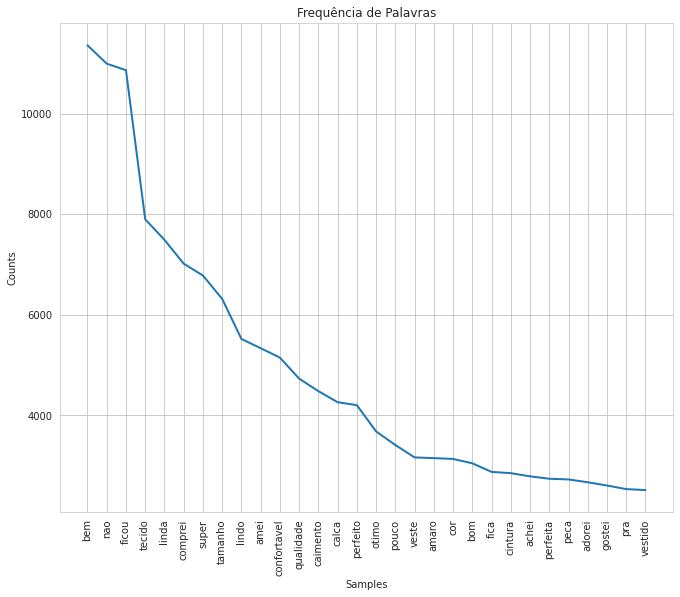

In [ ]:
from nltk.probability import FreqDist
tokens = [w for sublist in tokens_corpus for w in sublist]
fd = FreqDist(tokens)
print("40 palavras mais frequentes:")
print(fd.most_common(40))

plt.figure(figsize = (11, 9))
fd.plot(30, title = "Frequência de Palavras")

In [ ]:
#Vetorização do corpus final para futura modelagem. Usaremos a abordagem "Bag of words" atribuindo valores 
#aos tokens utilizando o método TFIDF (term frequency inverse document frequency)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#calculando os valores tf-idf
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(df_no_missing.REVIEW_CONTENT)

In [ ]:
import scipy.sparse   

X_df = pd.DataFrame.sparse.from_spmatrix(X)
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44004 entries, 0 to 44003
Columns: 21345 entries, 0 to 21344
dtypes: Sparse[float64, 0](21345)
memory usage: 5.5 MB


## 4. Modelagem

Vamos agora construir nosso modelo de classificação. Para isso, precisamos contruir nossa variável alvo. Vamos construí-la a partir da variável 'SCORE', criando dois valores para as classes: 'High' e 'Low'. Serão rotulados como 'High' todos os exemplos com score 4 e 5 e rotulados como 'Low' os demais casos. Depois, construíremos variáveis dummy para as variáveis categóricas e faremos a divisão do nosso dataset em conjuntos de treino e teste para então prosseguirmos com o treinamento do modelo. Não usaremos aqui a coluna 'CREATED_AT', que é do tipo datetime.

In [ ]:
#criando a variável alvo
df_no_missing.loc[df_no_missing['SCORE']>3,'LEVEL_SATISFACTION'] = 'High'
df_no_missing.loc[df_no_missing['SCORE']<4,'LEVEL_SATISFACTION'] = 'Low'
df_no_missing.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,DEPARTMENT,CATEGORY,REVIEW_CONTENT,SCORE,CREATED_AT,REVIEWER_TYPE,LEVEL_SATISFACTION
0,WOMEN'S FASHION,CLOTHING,"""Blusa perfeita, muito linda, elegante e sexy""",5.0,2021-03-30 23:55:24+00:00,"""verified_buyer""",High
1,WOMEN'S FASHION,CLOTHING,"""Tenho busto pequeno, não ficou um caimento no...",2.0,2021-02-17 18:24:10+00:00,"""verified_buyer""",Low
2,WOMEN'S FASHION,CLOTHING,"""Ficou um pouco mais apertada do que eu imagin...",3.0,2021-03-02 17:03:41+00:00,"""verified_buyer""",Low
3,WOMEN'S FASHION,CLOTHING,"""Comprem pelo tamanho de tabela. Perfeito !!!!!""",5.0,2016-11-30 20:19:04+00:00,"""anonymous_user""",High
4,WOMEN'S FASHION,SHOES,"""eu amei o sapato, chegou muito rápido e a qua...",5.0,2021-09-09 16:09:38+00:00,"""verified_buyer""",High


In [ ]:
#Checando a quantidade de exemplos em cada classe
df_no_missing['LEVEL_SATISFACTION'].value_counts()

High    38168
Low      5836
Name: LEVEL_SATISFACTION, dtype: int64

In [ ]:
#Criando dummies a partir das variáveis categóricas restantes
dummies = pd.get_dummies(df_no_missing[['DEPARTMENT', 'CATEGORY', 'REVIEWER_TYPE']])
dummies['LEVEL_SATISFACTION'] = df_no_missing['LEVEL_SATISFACTION'].map({'High':1,'Low':0})
dummies.head(10)

,DEPARTMENT_BEAUTY & PERSONAL CARE,DEPARTMENT_GIFT,DEPARTMENT_HOME & GARDEN,DEPARTMENT_INATIVO,DEPARTMENT_INDEFINIDO,DEPARTMENT_KIDS & BABIES,DEPARTMENT_NUTRITION & HEALTH,DEPARTMENT_WOMEN'S FASHION,CATEGORY_ACCESSORIES,CATEGORY_ACTIVEWEAR,...,CATEGORY_SHOES,CATEGORY_SKINCARE,CATEGORY_STATIONERY,CATEGORY_SWIMWEAR & BEACHWEAR,CATEGORY_TABLEWARE & KITCHENWARE,CATEGORY_VITAMINS & SUPPLEMENTS,"REVIEWER_TYPE_""anonymous_user""","REVIEWER_TYPE_""verified_buyer""","REVIEWER_TYPE_""verified_reviewer""",LEVEL_SATISFACTION
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
9,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
#DataFrame final para modelagem

df_encoded = dummies[:10000].reset_index(drop=True).merge(X_df,right_index=True, left_index=True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 21384 entries, DEPARTMENT_BEAUTY & PERSONAL CARE to 21344
dtypes: Sparse[float64, 0](21345), int64(1), uint8(38)
memory usage: 1.8 MB


In [ ]:
#Separação em conjuntos de treino e teste

from sklearn.model_selection import train_test_split

x = df_encoded.drop(['LEVEL_SATISFACTION'], axis = 1)
y = df_encoded['LEVEL_SATISFACTION']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123)

In [ ]:
# Treinando uma Random Forest com 10 árvores e pré-poda, estabelecendo um número mínimo de amostras para 
# quebra por árvore. Faremos uma cross-validation com 5 folds para cálculo do f1 score nos dados de treino

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=10, random_state=123, min_samples_split=100, class_weight='balanced')
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(clf, x_train, y_train, scoring="f1", cv=5, n_jobs=-1)
print(scores)

[0.93048128 0.92881878 0.92414861 0.92851593 0.92918288]


## 5. Avaliação do modelo

Vamos avaliar agora como o modelo generaliza para os dados de teste. Utilizaremos a área sob a curva ROC (Receiver Operating Characteristic) para quantificar o desempenho do modelo e plotaremos a curva ROC para melhor visualização.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

clf.fit(x_train,y_train)
y_pred = clf.predict_proba(x_test)
print('Área sob a curva ROC: ', roc_auc_score(y_test, y_pred[:,1]))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred[:,1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Área sob a curva ROC:  0.8668230404453834


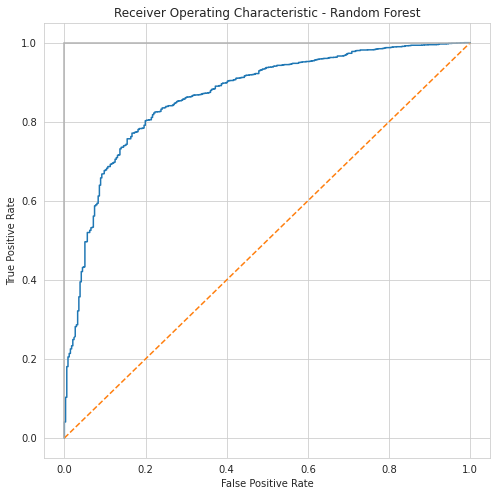

In [ ]:
plt.subplots(1, figsize=(8,8))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Vemos que nosso modelo apresenta um AUC=0.87, o que é razoável numa primeira etapa de construção do modelo. Futuramente seria interessante usar o método de GridSearch para escolher os melhores hiperparâmetros do classificador com o intuito de melhorar a performance. Também como sugestão futura seria interessante utilizar a variável do tipo datetime 'CREATED_AT' para fazer uma análise temporal dos dados, com o intuito de verificar algum comportamento anômalo no tempo. 